In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
def load_data():
    conn = mysql.connector.connect(
        host="localhost",
        port=3307,
        user="root",
        password="",
        database="Vendors_analysis"
    )
    orders = pd.read_sql("SELECT * FROM orders", conn)
    returns = pd.read_sql("SELECT * FROM returns", conn)
    vendors = pd.read_sql("SELECT * FROM vendors", conn)
    deliveries = pd.read_sql("SELECT * FROM deliveries", conn)
    conn.close()
    return orders, returns, vendors, deliveries


In [3]:
def clean_data(orders, returns, vendors, deliveries):
    orders = orders[orders['order_id'] != 0]
    returns = returns[returns['return_id'] != 0]
    vendors = vendors[vendors['vendor_id'] != 0]

    orders['order_date'] = pd.to_datetime(orders['order_date'], errors='coerce')
    returns['return_date'] = pd.to_datetime(returns['return_date'], errors='coerce')
    deliveries['delivery_date'] = pd.to_datetime(deliveries['delivery_date'], errors='coerce')

    orders['quantity'] = pd.to_numeric(orders['quantity'], errors='coerce')
    deliveries['quality_score'] = pd.to_numeric(deliveries['quality_score'], errors='coerce')

    deliveries['quality_score'].fillna(deliveries['quality_score'].mean(), inplace=True)
    return orders, returns, vendors, deliveries


In [4]:
def eda_plots(vendors, deliveries):
    plt.figure(figsize=(8,5))
    sns.countplot(data=vendors, x='category')
    plt.title("Vendor Category Counts")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.histplot(deliveries['quality_score'], bins=10)
    plt.title("Delivery Quality Scores")
    plt.tight_layout()
    plt.show()


In [5]:
def prepare_clustering_data(orders, deliveries, returns):
    order_qty = orders.groupby('vendor_id')['quantity'].sum().reset_index()
    deliveries_orders = pd.merge(deliveries, orders[['order_id', 'vendor_id']], on='order_id')
    avg_quality = deliveries_orders.groupby('vendor_id')['quality_score'].mean().reset_index()
    returns_orders = pd.merge(returns, orders[['order_id', 'vendor_id']], on='order_id')
    returns_count = returns_orders.groupby('vendor_id')['return_id'].count().reset_index().rename(columns={'return_id':'returns_count'})

    cluster_df = order_qty.merge(avg_quality, on='vendor_id', how='left').merge(returns_count, on='vendor_id', how='left')
    cluster_df.fillna(0, inplace=True)
    return cluster_df


In [6]:
def run_clustering(cluster_df, n_clusters=3):
    features = ['quantity', 'quality_score', 'returns_count']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_df[features])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    cluster_df['cluster'] = cluster_labels
    sil_score = silhouette_score(scaled_features, cluster_labels)
    print(f'Silhouette Score for {n_clusters} clusters: {sil_score:.3f}')
    return cluster_df

    


In [7]:
def plot_clusters(cluster_df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=cluster_df, x='quantity', y='quality_score', hue='cluster', palette='Set2', s=100)
    plt.title('Vendor Clusters by Quantity and Quality Score')
    plt.tight_layout()
    plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_12256\569527668.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders = pd.read_sql("SELECT * FROM orders", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_12256\569527668.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  returns = pd.read_sql("SELECT * FROM returns", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_12256\569527668.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vendors = pd.read_sql("SELECT * FROM vendors", conn)
C:\Users\hp\AppData\Local\Temp\ipykernel_12

✅ Data loaded and cleaned.


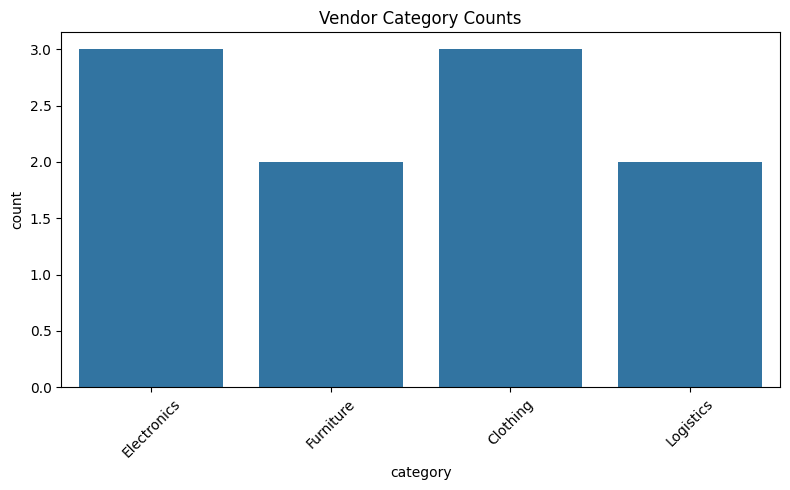

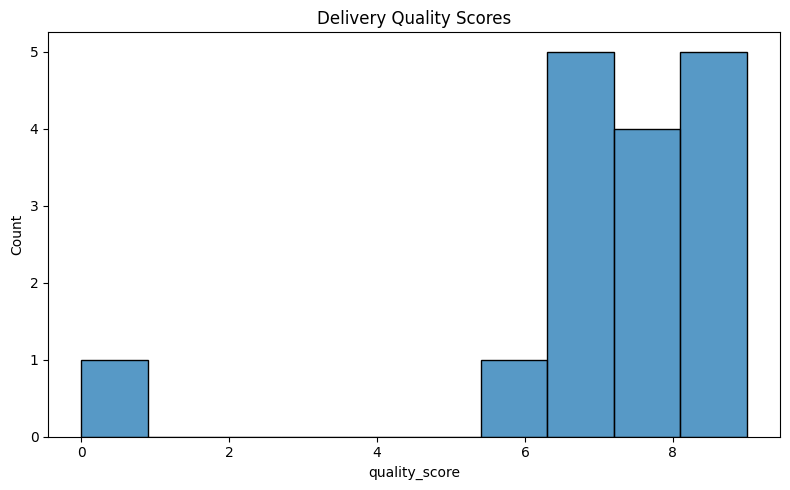

Silhouette Score for 3 clusters: 0.194
   vendor_id  quantity  quality_score  returns_count  cluster
0          1       238            8.0            1.0        0
1          2       177            8.5            2.0        2
2          3       100            7.5            2.0        2
3          4       292            8.5            1.0        0
4          5       192            7.5            1.0        1


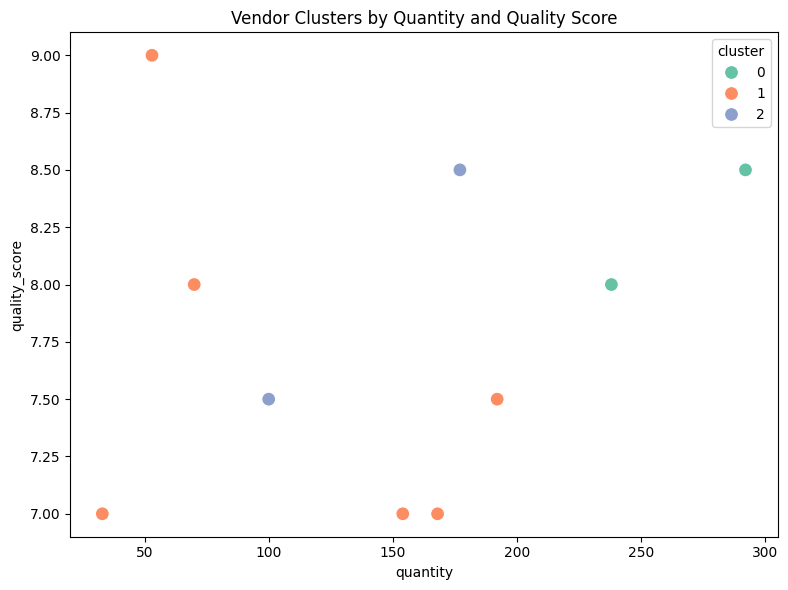

📁 Files saved: vendors_cleaned.csv & clustered_vendors.csv


In [8]:
# Load and clean
orders, returns, vendors, deliveries = load_data()
orders, returns, vendors, deliveries = clean_data(orders, returns, vendors, deliveries)
print("✅ Data loaded and cleaned.")

# EDA
eda_plots(vendors, deliveries)

# Clustering
cluster_df = prepare_clustering_data(orders, deliveries, returns)
cluster_df = run_clustering(cluster_df)
print(cluster_df.head())

# Plot clusters
plot_clusters(cluster_df)

# Save results
deliveries.to_csv("vendors_cleaned.csv", index=False)
cluster_df.to_csv("clustered_vendors.csv", index=False)
print("📁 Files saved: vendors_cleaned.csv & clustered_vendors.csv")
